In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Applications

In [3]:
from pyha.cores import DCRemoval
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

## Remove DC component from complex signal

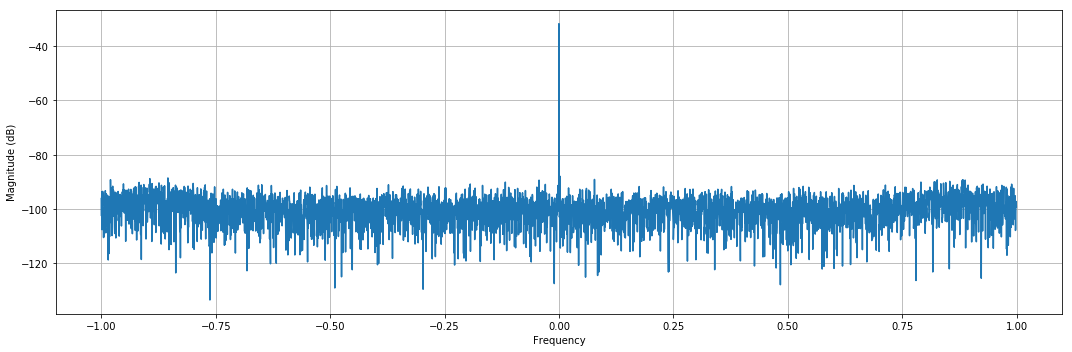

In [4]:
import inspect
import os
file = os.path.dirname(inspect.getfile(DCRemoval)) + '/dcspike_bladerf_20m.npy'
input_signal = np.load(file) # IQ samples
plt.magnitude_spectrum(input_signal, window=plt.mlab.window_none, scale='dB')
show_plot()

In [5]:
# NBVAL_IGNORE_OUTPUT
dut = DCRemoval(window_len=128, dtype=Complex)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 4097/4097 [00:00<00:00, 8979.14it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


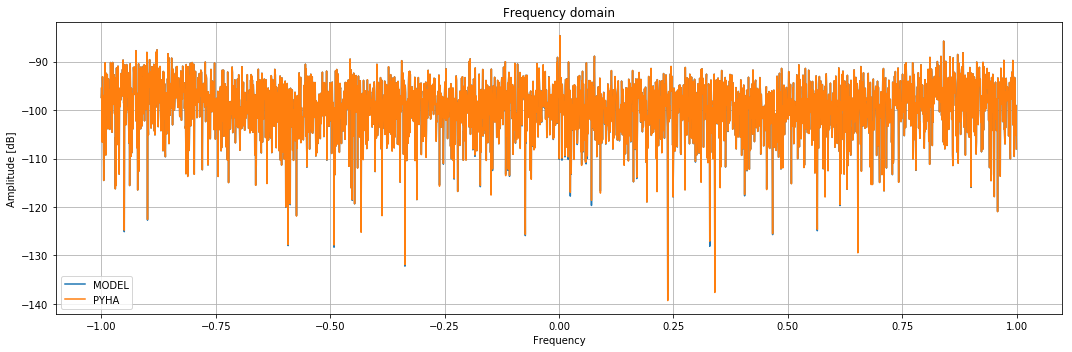

SNR: 41.70574502364378 dB


In [6]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(np.array(value)[1024:], window=plt.mlab.window_none, scale='dB', label=key)

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency')
show_plot()
print(f"SNR: {snr(sims['MODEL'], sims['PYHA'])} dB")

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [7]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Selection of ``window_len``
Optimal `window_len` depends on the sample rate. Too small length can result in messed up spectrum. 256 is an overall good value and is tested up to 80M sample rate with LimeSDR. `window_len` controls the BRAM usage.

# Synthesis

In [8]:
# NBVAL_SKIP
output_dir = '/tmp/pyha_output'
dut = DCRemoval(window_len=128, dtype=Complex)
sims = simulate(dut, input_signal[:1024], simulations=['PYHA', 'RTL', 'GATE'], conversion_path=output_dir)

assert hardware_sims_equal(sims)

lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1025/1025 [00:00<00:00, 2162.12it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:MovingAverage to VHDL ...


INFO:conversion:DCRemoval to VHDL ...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:DCRemoval to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 24 13:56:38 2018
INFO:sim:Quartus Prime Version : 18.0.0 Build 614 04/24/2018 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 522
INFO:sim:    Total combinational functions : 486
INFO:sim:    Dedicated logic registers : 302
INFO:sim:Total registers : 302
INFO:sim:Total pins : 74
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 18,108
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations

Logic elements: 522
Memory: 18108
Multipler (18bit): 0
